## **Gender Detection using UTK Face Dataset**

## Importing the Libraries

In [1]:
import tensorflow as tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D, Activation, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time

import cv2 # Importing OpenCV Library
import math
import argparse

from PIL import Image
from datetime import datetime

from sklearn.model_selection import train_test_split

## Loading DataSet from Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls -ltr "/content/drive/My Drive/Dataset"

total 587121
-rw------- 1 root root 301072766 Oct  1  2019 fer.csv
-rw------- 1 root root   4956565 Sep  1 00:12 landmark_list_part1.txt
-rw------- 1 root root   5440143 Sep  1 00:12 landmark_list_part2.txt
drwx------ 2 root root      4096 Sep  1 02:47 crop_part1
drwx------ 2 root root      4096 Sep  1 02:50 UTKFace
-rw------- 1 root root   1748776 Sep  1 20:19 utkface_data.txt
-rw------- 1 root root   1618353 Sep  2 00:07 utkface_data.csv
-rw------- 1 root root   1628446 Sep  2 00:53 landmark_list_part3.txt
-rw------- 1 root root    668592 Sep 13 00:13 crop_data.csv
-rw------- 1 root root 284059736 Sep 13 19:32 gender_detection_model.h5
-rw------- 1 root root      7730 Sep 13 19:32 gender_detect.json


### Reusable Functions for pixel extraction

In [4]:
## Function to get image pixels and Gender

def get_image_dataset(file_path):
  Start_time = datetime.now()
  i = 1
  files_path = os.listdir(file_path)   ## To get list of files in directory
  files_data = []
  for file in files_path:
    x = file.split("_")                 ## Splitting the data since file name consists of [age]_[gender]_[race]_[date&time].jpg
    file_name = file_path+file          
    #print(file_name)
    img = Image.open(file_name)         ## Opening the image file
    img = np.array(img).reshape(200 * 200 * 3)    ## Converting the image in an array of pixels and reshaping it
    #print(img.shape)
    files_data.append([file,int(x[1]),img])       ## Adding the details in an array
    print(i)
    i +=1
    #if i > 100:
    #  break;

  
  df = pd.DataFrame(files_data, columns=['File_name','Gender', 'Pixels'])   ## Converting the array into Dataframe for model
  end_time = datetime.now()
  print(Start_time,end_time)
  return df

In [5]:
## Function to save the values in a CSV file

def save_image_details(df_image,file_name,path_to_save=None):
  ## Converting pixels into string in new column
  df_image['Pixels_value'] = df_image['Pixels'].apply(lambda x: ','.join(map(str, x)))
  ## Saving the dataframe
  file_name = path_to_save+"/"+file_name
  ## Saving erequired columns into csv file
  df_image[['File_name','Gender', 'Pixels_value']].to_csv(file_name,sep="\t",header= True,index=False)

  ## checking if file is created
  if os.path.exists(file_name):
    print("File Created as: "+ file_name)
    print("Last modified: %s" % time.ctime(os.path.getmtime(file_name)))
    print("Created: %s" % time.ctime(os.path.getctime(file_name)))
    return True
  else:
    print("File not created")
    return False


In [6]:
## Function to get image details from CSV file

def get_image_details(file_name,path_to_save=None):
  ## File Name with absolute path
  file_name = path_to_save+"/"+file_name
  ##Checking if file exists
  if os.path.exists(file_name):
    print("File Created as: "+ file_name)
    print("Last modified: %s" % time.ctime(os.path.getmtime(file_name)))
    print("Created: %s" % time.ctime(os.path.getctime(file_name)))
    ## Reading the data from csv file
    df_new = pd.read_csv(file_name, sep='\t')
    ## Changing string value to list
    df_new['Pixels'] = df_new.Pixels_value.apply(lambda x: x.strip('()').split(','))
    ## Changing datatype to float32
    df_new['Pixels'] = df_new.apply(lambda row: np.array(np.float32(row.Pixels)), axis=1)
    ## Dropping not used column
    df_new.drop('Pixels_value', inplace=True, axis=1)
    ## returing dataframe for further analysis
    return df_new
  else:
    print("File not present")
    return False
  

### Extract Data Using Crop Data Set

In [7]:
df_subset = get_image_dataset('/content/drive/MyDrive/Dataset/crop_part1/')

Streaming output truncated to the last 5000 lines.
4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859
4860
4861
4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885
4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899
4900
4901
4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971

In [8]:
df_subset.head(10)

,File_name,Gender,Pixels
0,3_1_0_20170109191958848.jpg.chip.jpg,1,"[75, 56, 39, 81, 62, 45, 84, 65, 48, 79, 60, 4..."
1,3_1_0_20170109192003664.jpg.chip.jpg,1,"[169, 130, 99, 135, 98, 69, 96, 64, 39, 72, 45..."
2,3_1_0_20170109192006973.jpg.chip.jpg,1,"[25, 21, 18, 28, 25, 20, 35, 30, 26, 42, 37, 3..."
3,3_1_0_20170109192130439.jpg.chip.jpg,1,"[163, 103, 77, 175, 113, 88, 185, 123, 98, 190..."
4,3_1_0_20170109192027975.jpg.chip.jpg,1,"[172, 172, 160, 162, 162, 152, 143, 143, 133, ..."
5,3_1_0_20170109192304730.jpg.chip.jpg,1,"[59, 74, 67, 66, 81, 74, 81, 94, 84, 98, 109, ..."
6,3_1_0_20170109192346475.jpg.chip.jpg,1,"[222, 185, 130, 223, 186, 131, 218, 181, 126, ..."
7,3_1_0_20170109192434126.jpg.chip.jpg,1,"[153, 135, 149, 165, 145, 157, 176, 156, 167, ..."
8,3_1_0_20170109192420753.jpg.chip.jpg,1,"[251, 255, 250, 251, 255, 250, 251, 255, 252, ..."
9,3_1_0_20170109192746527.jpg.chip.jpg,1,"[76, 54, 30, 75, 53, 29, 74, 52, 28, 72, 50, 2..."


In [16]:
## Writing data to a txt file

check = save_image_details(df_subset,'data_crop_set.csv',r'/content/drive/MyDrive/Dataset/')
if check:
  del df_subset

File Created as: /content/drive/MyDrive/Dataset//data_crop_set.csv
Last modified: Tue Sep 14 17:18:39 2021
Created: Tue Sep 14 17:18:39 2021


In [ ]:
df_subset = get_image_details('data_crop_set.csv',r'/content/drive/MyDrive/Dataset/')

File Created as: /content/drive/MyDrive/Dataset//data_crop_set.csv
Last modified: Tue Sep 14 17:18:39 2021
Created: Tue Sep 14 17:18:39 2021


In [ ]:
## Converting it into Float 32
df_subset['Pixels'] = df_subset.apply(lambda row: np.array(np.float32(row.Pixels)), axis=1)

In [9]:
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9780 entries, 0 to 9779
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File_name  9780 non-null   object
 1   Gender     9780 non-null   int64 
 2   Pixels     9780 non-null   object
dtypes: int64(1), object(2)
memory usage: 229.3+ KB


In [10]:
## Count of each gender
df_subset.groupby("Gender").count()

# 0 = Male
# 1 = Female

,File_name,Pixels
Gender,,
0,4372,4372
1,5407,5407
3,1,1


In [11]:
## Creating copy of Dataframe to be used later for verification
df = df_subset.copy()

In [12]:
del df_subset

### Extract Data Using UTKFace Set

In [ ]:
df = get_image_dataset('/content/drive/MyDrive/Dataset/UTKFace/')

In [ ]:
## Writing data to a txt file

df.to_csv('/content/drive/MyDrive/Dataset/utkface_data.csv',sep="\t",header= False,index=False)

In [ ]:
df.head(10)

,File_name,Gender,Pixels
0,56_0_3_20170119180731484.jpg.chip.jpg,0,"[44, 56, 42, 44, 56, 42, 47, 60, 43, 56, 69, 5..."
1,56_0_3_20170119180848388.jpg.chip.jpg,0,"[122, 111, 109, 122, 111, 109, 122, 111, 109, ..."
2,56_0_3_20170119180916188.jpg.chip.jpg,0,"[102, 68, 66, 103, 69, 67, 104, 70, 68, 104, 6..."
3,56_0_3_20170119174930466.jpg.chip.jpg,0,"[147, 148, 150, 148, 149, 151, 149, 150, 152, ..."
4,56_0_0_20170119181226587.jpg.chip.jpg,0,"[135, 100, 94, 135, 100, 94, 135, 100, 94, 135..."
5,56_0_3_20170119183551541.jpg.chip.jpg,0,"[100, 71, 67, 104, 75, 71, 110, 79, 76, 115, 8..."
6,56_0_3_20170119152358239.jpg.chip.jpg,0,"[51, 42, 45, 53, 43, 44, 53, 43, 44, 53, 41, 4..."
7,56_1_3_20170119181445803.jpg.chip.jpg,1,"[200, 207, 217, 202, 209, 219, 199, 206, 216, ..."
8,56_0_3_20170119211644664.jpg.chip.jpg,0,"[126, 135, 132, 130, 139, 138, 136, 146, 145, ..."
9,56_0_3_20170119192008015.jpg.chip.jpg,0,"[58, 49, 44, 61, 52, 47, 64, 55, 50, 68, 57, 5..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File_name  23708 non-null  object
 1   Gender     23708 non-null  int64 
 2   Pixels     23708 non-null  object
dtypes: int64(1), object(2)
memory usage: 555.8+ KB


In [ ]:
## Count of each gender
df.groupby("Gender").count()

,File_name,Pixels
Gender,,
0,12391,12391
1,11317,11317


In [ ]:
## Converting it into Float 32

df['Pixels'] = df.apply(lambda row: np.array(np.float32(row.Pixels)), axis=1)

In [ ]:
df.head(10)

- Loading the dataset from image take a lot of time in converting the image to an array and then reshaping it.
- So using file for extracting image details

## Loading the Dataset from File

In [ ]:
## Function to get data from file into dataframe

def get_dataset(file_name):
    
    data_set = []
    with open(filename) as file:
        i = 0
        for line in file:
            data = line.split(" ")
            #print(str(data[1:137]).replace(","," ").replace("\'","").replace("[","").replace("]",""))
            #print(list(map(int, data[1:137])))
            #print(data[0])

            data_set.append([data[0],data[0].split("_")[1],list(map(int, data[1:137]))])
        
            i +=1
        
            #if i >5:
            #    break;
            #print(i)

    df = pd.DataFrame(data_set)
    del data_set
    return df

In [ ]:
## Getting data from different files
filename = r'/content/drive/MyDrive/Dataset/landmark_list_part1.txt'
df1 = get_dataset(filename)
filename = r'/content/drive/MyDrive/Dataset/landmark_list_part2.txt'
df2 = get_dataset(filename)
filename = r'/content/drive/MyDrive/Dataset/landmark_list_part3.txt'
df3 = get_dataset(filename)

In [ ]:
df = pd.concat([df1, df2, df3], ignore_index=True, sort=False)

In [ ]:
df2 = df.rename({0: 'Filename', 1: 'Gender',2:'Pixels'}, axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  23708 non-null  object
 1   Gender    23708 non-null  object
 2   Pixels    23708 non-null  object
dtypes: object(3)
memory usage: 555.8+ KB


## Performing Data Exploration

In [13]:
## Count of each gender
df.groupby("Gender").count()

# 0 = Male
# 1 = Female

,File_name,Pixels
Gender,,
0,4372,4372
1,5407,5407
3,1,1


In [14]:
## Deleting 1 row where Gender is 3
df.drop( df[ df['Gender'] == '3' ].index , inplace=True)

In [15]:
## Converting it into Float 32

df['Pixels'] = df.apply(lambda row: np.array(np.float32(row.Pixels)), axis=1)

In [16]:
df_img = df.copy()

In [17]:
del df_img

In [18]:
## Normalising the data
df['Pixels'] = df['Pixels']/255

In [19]:
df['Gender'] = pd.to_numeric(df['Gender']) ##df['Gender'].astype(int)

In [20]:
print(df['Gender'])

0       1
1       1
2       1
3       1
4       1
       ..
9775    0
9776    1
9777    0
9778    1
9779    1
Name: Gender, Length: 9780, dtype: int64


In [21]:
## Performing One Hot encoding on Gender column

one_hot = pd.get_dummies(df['Gender'])
one_hot.drop(columns=[0,3],axis = 1, inplace=True)
one_hot.rename(columns = {1:'Gender_F'}, inplace=True)

In [22]:
print(one_hot)

      Gender_F
0            1
1            1
2            1
3            1
4            1
...        ...
9775         0
9776         1
9777         0
9778         1
9779         1

[9780 rows x 1 columns]


In [ ]:
#one_hot.drop(columns=[3],axis = 1, inplace=True)

In [23]:
df = df.join(one_hot)

In [24]:
del one_hot

In [25]:
df.drop(columns=['Gender'],axis = 1, inplace=True)
df.rename(columns = {'Gender_F':'Gender'}, inplace=True)

In [26]:
df.head()

,File_name,Pixels,Gender
0,3_1_0_20170109191958848.jpg.chip.jpg,"[0.29411766, 0.21960784, 0.15294118, 0.3176470...",1
1,3_1_0_20170109192003664.jpg.chip.jpg,"[0.6627451, 0.50980395, 0.3882353, 0.5294118, ...",1
2,3_1_0_20170109192006973.jpg.chip.jpg,"[0.09803922, 0.08235294, 0.07058824, 0.1098039...",1
3,3_1_0_20170109192130439.jpg.chip.jpg,"[0.6392157, 0.40392157, 0.3019608, 0.6862745, ...",1
4,3_1_0_20170109192027975.jpg.chip.jpg,"[0.6745098, 0.6745098, 0.627451, 0.63529414, 0...",1


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9780 entries, 0 to 9779
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File_name  9780 non-null   object
 1   Pixels     9780 non-null   object
 2   Gender     9780 non-null   uint8 
dtypes: object(2), uint8(1)
memory usage: 558.8+ KB


In [28]:
## Count of each gender
df.groupby("Gender").count()

,File_name,Pixels
Gender,,
0,4373,4373
1,5407,5407


In [29]:
## Getting the shape of dataframe
df.shape

(9780, 3)

In [ ]:
#img_size = (17,8,1)
img_size = (200,200,3)
def view_image(data, row_id,img_size_in):
  gender = {0 : "Male", 1 : "Female"}
  num_emotion = int(data['Gender'][row_id])
  print(num_emotion, gender[num_emotion])
  img = np.array(np.float32(data['Pixels'][row_id]).reshape(img_size_in))
  pil_img = tensorflow.keras.preprocessing.image.array_to_img(img)
  imgplot = plt.imshow(pil_img)
  plt.show()

0 Male


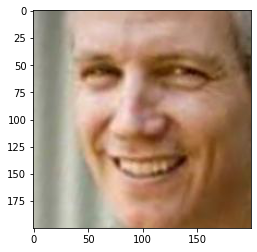

In [ ]:
view_image(df_img,674,img_size)

In [ ]:
df_img['Gender'][674]

0

## Test Train Data Split

In [30]:
## Train and test split

X_train, X_test, Y_train, Y_test = train_test_split(df['Pixels'],df['Gender'],test_size=0.2,train_size=0.8)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(type(X_train))

(7824,)
(1956,)
(7824,)
(1956,)
<class 'pandas.core.series.Series'>


In [31]:
## reshaping the data sets
X_train = np.array(X_train.to_list())
X_test = np.array(X_test.to_list())

In [ ]:
#X_train = X_train.reshape(X_train.shape[0], 17, 8, 1) 
#X_test = X_test.reshape(X_test.shape[0], 17, 8, 1)

In [32]:
X_train = X_train.reshape(X_train.shape[0], 200, 200, 3) 
X_test = X_test.reshape(X_test.shape[0], 200,200, 3)

## Building Model

In [33]:
## Function to get Model Stats

def model_stats(training_model):
  print(training_model.history.keys())
  # summarize training for accuracy
  plt.plot(training_model.history['accuracy'])
  plt.plot(training_model.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize traning for loss
  plt.plot(training_model.history['loss'])
  plt.plot(training_model.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [34]:
## Creating model

def gender_detection(input_shape,fun_activation='relu',dropout_value = 0.2,fun_loss = 'binary_crossentrophy',fun_optimizer = 'Adam'):
  model = Sequential()
  model.add(Conv2D(filters=64,kernel_size=(5,5),input_shape = input_shape,activation = fun_activation, padding='same'))
  model.add(Conv2D(filters=64, kernel_size=(5,5),activation=fun_activation, padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters=128,kernel_size=(5,5),input_shape = input_shape,activation = fun_activation, padding='same'))
  model.add(Conv2D(filters=128, kernel_size=(5,5),activation=fun_activation, padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters=256,kernel_size=(5,5),input_shape = input_shape,activation = fun_activation, padding='same'))
  model.add(Conv2D(filters=256, kernel_size=(5,5),activation=fun_activation, padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(128, activation=fun_activation))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(1,activation='softmax'))

  model.compile(optimizer=fun_optimizer,loss=fun_loss,metrics=['accuracy'])

  return model

#input_shape = (17,8,1)
input_shape = (200,200,3)
model = gender_detection(input_shape,'relu',0.3,'binary_crossentropy','Adam')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 64)      4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 64)      102464    
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 128)     204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 128)     409728    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 128)     5

In [35]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, ## increasing the patience
                                            verbose=2, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [36]:
## Traning basic model
gender = model.fit( x = X_train, y = Y_train, 
                    batch_size = 64, 
                    epochs = 30, 
                    verbose = 2,
                    validation_split=0.2,
                    callbacks= callbacks
                    )

Epoch 1/30
98/98 - 109s - loss: 0.7024 - accuracy: 0.5571 - val_loss: 0.5996 - val_accuracy: 0.5438
Epoch 2/30
98/98 - 60s - loss: 0.5213 - accuracy: 0.5571 - val_loss: 0.6037 - val_accuracy: 0.5438
Epoch 3/30
98/98 - 60s - loss: 0.4663 - accuracy: 0.5571 - val_loss: 0.6953 - val_accuracy: 0.5438
Epoch 4/30
98/98 - 60s - loss: 0.4126 - accuracy: 0.5571 - val_loss: 0.5421 - val_accuracy: 0.5438

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/30
98/98 - 60s - loss: 0.3474 - accuracy: 0.5571 - val_loss: 0.4162 - val_accuracy: 0.5438
Epoch 6/30
98/98 - 60s - loss: 0.3164 - accuracy: 0.5571 - val_loss: 0.4116 - val_accuracy: 0.5438
Epoch 7/30
98/98 - 60s - loss: 0.2850 - accuracy: 0.5571 - val_loss: 0.3797 - val_accuracy: 0.5438

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 8/30
98/98 - 60s - loss: 0.2184 - accuracy: 0.5571 - val_loss: 0.3662 - val_accuracy: 0.5438
Epoch 9/30
98/98 - 60s - loss: 0.1860 - accur

In [ ]:
## Saving the model with best accuracy

model.save("/content/drive/MyDrive/Dataset/gender_detection_model.h5")

In [ ]:
## Saving model to JSON

gen_detect = model.to_json()
with open("/content/drive/MyDrive/Dataset/gender_detect.json", "w") as json_file:
    json_file.write(gen_detect)

In [6]:
#load model
from keras.models import model_from_json
model = model_from_json(open("/content/drive/MyDrive/Dataset/gender_detect.json", "r").read())
#load weights
model.load_weights('/content/drive/MyDrive/Dataset/gender_detection_model.h5')

In [37]:
model.evaluate(X_test,Y_test, verbose=2)

62/62 - 12s - loss: 0.4138 - accuracy: 0.5465


[0.41382887959480286, 0.5465235114097595]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


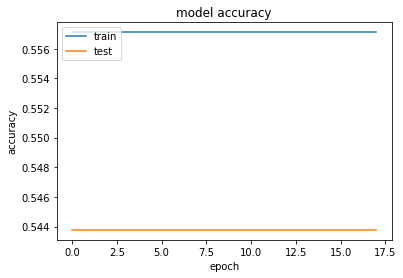

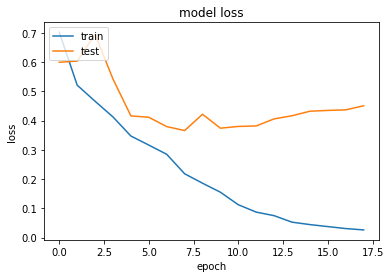

In [38]:
## Gathering model stats
model_stats(gender)

In [79]:
from skimage import io
import warnings
warnings.filterwarnings("ignore")

def model_verify(model,image_name=None):
  gender_type = {0.0:'Male',1.0:'Female'}

  print("Image Name: "+image_name)
  #File_name= '/content/drive/MyDrive/Dataset/UTKFace/'+image_name+'.chip.jpg'
  #img = image.load_img(File_name, grayscale=True, target_size=(17, 8, 1))
  File_name= '/content/drive/MyDrive/Dataset/UTKFace/'+image_name
  img = Image.open(File_name)         ## Opening the image file
  img = np.array(img)#.reshape(200 * 200 * 3)
  #print(img.shape)
  #img = image.load_img(File_name, grayscale=True, target_size=None) #(200, 200, 3))
  show_img=image.load_img(File_name, grayscale=False, target_size=None)#(200, 200, 3))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  #print(x)
  x /= 255
  #print(x.shape)
  custom = model.predict(x)
  print("Prediction ---> "+ gender_type[custom[0][0]])
  #print(gender_type[custom[0][0]])
  #print(custom[0])
  #emotion_analysis(custom[0])

  x = np.array(x, 'float32')
  x = x.reshape([200, 200, 3])

  print("Image --->")
  plt.gray()
  plt.imshow(show_img)
  plt.xticks([])
  plt.yticks([])

  plt.show()
  


Image Name: 5_1_0_20170109193951363.jpg.chip.jpg
Prediction ---> Female
Image --->


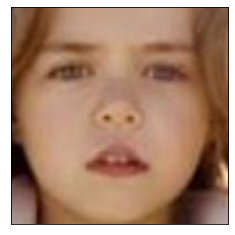

In [81]:
model_verify(model,df['File_name'][120])

Image Name: 70_1_0_20170110122856556.jpg.chip.jpg
Prediction ---> Female
Image --->


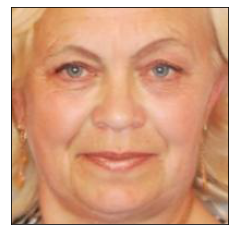

In [82]:
model_verify(model,df['File_name'][896])

#df.head()

Image Name: 12_1_0_20170109204241570.jpg.chip.jpg
Prediction ---> Female
Image --->


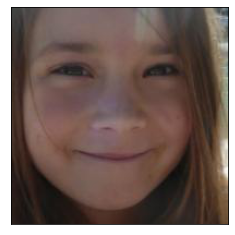

In [86]:
model_verify(model,df['File_name'][245])

Image Name: 1_0_0_20161219193326339.jpg.chip.jpg
Prediction ---> Female
Image --->


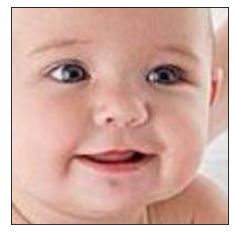

In [89]:
model_verify(model,df['File_name'][9540])

## Predicting with Model using Haar Cascade in Realtime

In [90]:
## Importing Libraries

import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

In [91]:
#load model
model_realtime = model_from_json(open("/content/drive/MyDrive/Dataset/gender_detect.json", "r").read())
#load weights
model_realtime.load_weights('/content/drive/MyDrive/Dataset/gender_detection_model.h5')

#loading Haar Cascade weights
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
## Detecting the Gender in real time

cap=cv2.VideoCapture(0)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        roi_gray=cv2.resize(roi_gray,(48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255

        gender_type = {0.0:'Male',1.0:'Female'}
        predictions = model_realtime.predict(img_pixels)

        
        gender_type[predictions[0][0]]

        #find max indexed array
        predicted_gender = gender_type[predictions[0][0]]

        cv2.putText(test_img, predicted_gender, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('Facial emotion analysis ',resized_img)



    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows